In [2]:
In this example, we take the Sanfrancisco 311 Call center data for last 10 years and
use this to predict the Call volumeof the next 3 months, and show the Root mean square error (RMSE), 
using different approaches, ie the traditional ARMA, and Deep Learning techniques like Sequence models with LSTM 
in different ways.

In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from pandas import DataFrame
from pandas import concat
from keras.models import load_model
from keras import optimizers
from matplotlib import pyplot
from math import sqrt
from keras import optimizers

numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('/home/anirban/Downloads/311_call_metrics.csv', header=0, engine='python', skipfooter=3)
dataframe.head()

Using TensorFlow backend.


,month,calls_answered,svc_level_answered_w_i_60_sec,avg_speed_answer_sec,transferred_calls
0,2015-12-01T00:00:00,71042,0.437,138.0,0.083
1,2015-11-01T00:00:00,70038,0.438,149.0,0.086
2,2015-10-01T00:00:00,73047,0.323,191.0,0.091
3,2015-09-01T00:00:00,74445,0.411,124.0,0.089
4,2015-08-01T00:00:00,73027,0.326,217.0,0.096


In [3]:
corr_matrix = dataframe.corr()
corr_matrix["avg_speed_answer_sec"].sort_values(ascending=False)
corr_matrix["calls_answered"].sort_values(ascending=False)

calls_answered                   1.000000
svc_level_answered_w_i_60_sec    0.455217
avg_speed_answer_sec            -0.605058
transferred_calls               -0.850102
Name: calls_answered, dtype: float64

In [ ]:
The correlation matrix shows high correlation between the calls_answered and transferred_calls. 
In order to minimize transferred calls, it is important to predict the call volume accurately

In [ ]:
Next we sort the data based on the month and plot the data, to observe the trends. Since we are now going to 
predict the Call Volume of next 3 months based on historical data of Call Volume, we take the month and 
Call volume in our dataset

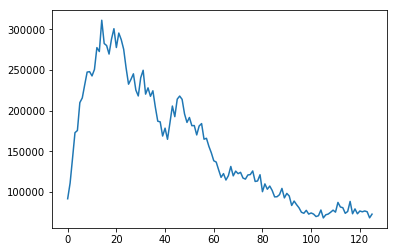

In [4]:
dataframe['month'] = pd.to_datetime(dataframe.month)
dataframe=dataframe.sort_values(by='month',ascending=True)
dataframe = dataframe.iloc[:,0:2]
dataset = dataframe.values[:,1:2]
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()

In [ ]:
Next we Scale the dataset using MinMaxScaler in a range of 0 to 1

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
We split the train and test data. We have 120 values, worth of 10 years of data, on a monthly basis. We take
20 values as test data, and remaining as train data. Since this is time series data, we take the first 106 values
as train data and next 20 values as test data

In [6]:
train_size = int(len(dataset)) - 20
test_size = 20
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

106 20


In [ ]:
The next part is the most important step in creating the train data for a Supervised Learning problem.
We shift the data with a lookback of 10 time steps and use this data to predict the value of the Call volume 
at the next time step.

In [7]:

def createSupervisedTrainingSet(dataset,lookback):

    df = DataFrame()
    x = dataset
    
    len_series = x.shape[0]

    df['t'] = [x[i] for i in range(x.shape[0])]
    #create x values at time t
    x=df['t'].values
    
    cols=list()
    #create dataframe series for t+1,t+2,t+3, to be used as y values, during Supervised Learning
    #lookback = 10, means 10 values of x are used to predict the value of y at time t+1,t+2,t+3

    df['t+1'] = df['t'].shift(-lookback)
    cols.append(df['t+1'])
    df['t+2'] = df['t'].shift(-(lookback+1))
    cols.append(df['t+2'])
    df['t+3'] = df['t'].shift(-(lookback+2))
    cols.append(df['t+3'])
    agg = concat(cols,axis=1)
    y=agg.values

    x = x.reshape(x.shape[0],1)

    len_X = len_series-lookback-2
    X=np.zeros((len_X,lookback,1))
    Y=np.zeros((len_X,3))
 
    for i in range(len_X):
        X[i] = x[i:i+10]
        Y[i] = y[i]

    return X,Y
 

look_back = 10
trainX, trainY = createSupervisedTrainingSet(train, look_back)
testX,testY = createSupervisedTrainingSet(test, look_back)

In [16]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
#Check the sample train X and train Y, as well as test X and test Y, and match with original time series data
print(np.around(scaler.inverse_transform(testX[7,:])))
print(np.around(scaler.inverse_transform(testY[7,:])))
print(np.around(scaler.inverse_transform(trainX[93,:,:])))
print(np.around(scaler.inverse_transform(trainY[93,:])))
print(np.around(scaler.inverse_transform(dataset[93:106])))        
#use a lookback value of 10, so the value at t is 10 steps behind the value at t+1
#As can be seen the 10 values of Time Series (Call Volume) from index 93 are being used as X to 
#predict the 3 values coming next (t+1,t+2,t+3)

(94, 10, 1)
(94, 3)
(8, 10, 1)
(8, 3)
[[ 80919.]
 [ 74029.]
 [ 76264.]
 [ 88607.]
 [ 73473.]
 [ 79410.]
 [ 73427.]
 [ 76847.]
 [ 75870.]
 [ 76892.]]
[ 75949.  68468.  72996.]
[[ 89074.]
 [ 84685.]
 [ 80836.]
 [ 75324.]
 [ 74064.]
 [ 77644.]
 [ 73027.]
 [ 74445.]
 [ 73047.]
 [ 70038.]]
[ 71042.  78059.  68355.]
[[ 89074.]
 [ 84685.]
 [ 80836.]
 [ 75324.]
 [ 74064.]
 [ 77644.]
 [ 73027.]
 [ 74445.]
 [ 73047.]
 [ 70038.]
 [ 71042.]
 [ 78059.]
 [ 68355.]]


/home/anirban/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/anirban/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [ ]:
Use a Deep Learning technique with one hidden layer of 20 LSTM cells, outputting into 3 values, ie the predictions
at time t+1,t+2,t+3. Input layer being 10 by 1 in size, for the 10 prior values of time series.

In [17]:
model = Sequential()
model.add(LSTM(20, input_shape=(look_back, 1)))
model.add(Dense(3))
myOptimizer = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=myOptimizer)
history = model.fit(trainX, trainY, epochs=100,  validation_data=(testX,testY), batch_size=5, verbose=2)

Train on 94 samples, validate on 8 samples
Epoch 1/100
 - 0s - loss: 0.1509 - val_loss: 0.0908
Epoch 2/100
 - 0s - loss: 0.0598 - val_loss: 0.1118
Epoch 3/100
 - 0s - loss: 0.0458 - val_loss: 0.0536
Epoch 4/100
 - 0s - loss: 0.0328 - val_loss: 0.0338
Epoch 5/100
 - 0s - loss: 0.0213 - val_loss: 0.0147
Epoch 6/100
 - 0s - loss: 0.0128 - val_loss: 0.0024
Epoch 7/100
 - 0s - loss: 0.0088 - val_loss: 0.0010
Epoch 8/100
 - 0s - loss: 0.0084 - val_loss: 0.0026
Epoch 9/100
 - 0s - loss: 0.0080 - val_loss: 0.0018
Epoch 10/100
 - 0s - loss: 0.0076 - val_loss: 0.0013
Epoch 11/100
 - 0s - loss: 0.0073 - val_loss: 7.8302e-04
Epoch 12/100
 - 0s - loss: 0.0076 - val_loss: 2.7188e-04
Epoch 13/100
 - 0s - loss: 0.0077 - val_loss: 2.7662e-04
Epoch 14/100
 - 0s - loss: 0.0074 - val_loss: 0.0015
Epoch 15/100
 - 0s - loss: 0.0073 - val_loss: 8.7634e-04
Epoch 16/100
 - 0s - loss: 0.0065 - val_loss: 5.5331e-04
Epoch 17/100
 - 0s - loss: 0.0080 - val_loss: 8.5202e-04
Epoch 18/100
 - 0s - loss: 0.0071 - val_l

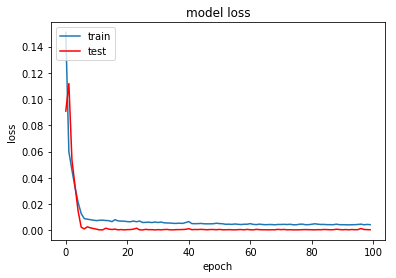

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color=  'red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Once the model is trained, use it to make a prediction on the test data

In [19]:
testPredict = model.predict(testX)
predictUnscaled = np.around(scaler.inverse_transform(testPredict))
testYUnscaled = np.around(scaler.inverse_transform(testY))
#print the actual and predicted values at t+3
print(testYUnscaled[:,2])
print(predictUnscaled[:,2])

[ 79410.  73427.  76847.  75870.  76892.  75949.  68468.  72996.]
[ 76833.  82395.  78006.  78314.  75541.  75645.  75507.  75978.]


In [ ]:
Plot the predicted and actual values at time t+1,t+2,t+3

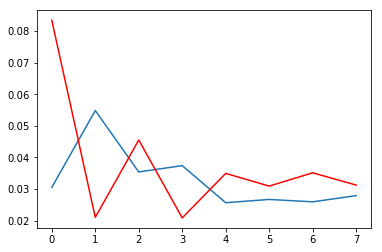

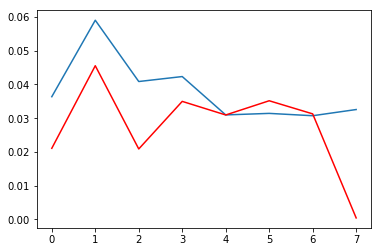

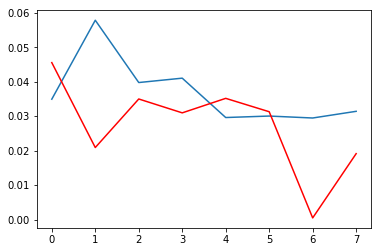

In [20]:
pyplot.plot(testPredict[:,0])
pyplot.plot(testY[:,0],color='red')
pyplot.show()

pyplot.plot(testPredict[:,1])
pyplot.plot(testY[:,1],color='red')
pyplot.show()

pyplot.plot(testPredict[:,2])
pyplot.plot(testY[:,2],color='red')
pyplot.show()

In [ ]:
Evaluate the RMSE values at t+1,t+2,t+3 to compare with other approaches, and select the best approach

In [21]:
def evaluate_forecasts(actuals, forecasts, n_seq):
    	for i in range(n_seq):
            actual = actuals[:,i]
            predicted = forecasts[:,i]
            rmse = sqrt(mean_squared_error(actual, predicted))
            print('t+%d RMSE: %f' % ((i+1), rmse))
        
evaluate_forecasts(testYUnscaled, predictUnscaled,3)

t+1 RMSE: 5765.188028
t+2 RMSE: 3753.886469
t+3 RMSE: 4398.008527


In [ ]:
It can be clearly seen, the RMSE values are much better than traditional ARMA models, and hence Deep Learning 
is useful in this scenario to predict the Call Volume at time t+1,t+2 and t+3